## Importamos librerias

In [1]:

# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importamos el data frame con pandas

In [2]:
df_raw = pd.read_csv("./bank_subscription (1).csv",delimiter=';',)

En el caso de las columnas numericas, vamos a rellenar los NaN con la media.

In [3]:
def fill_median(df):
    df_median = df.copy()
    # Calculo de media de cada columna
    median_age = df_median['Age'].median()
    median_balance = df_median['Balance (euros)'].median()
    median_duration = df_median['Last Contact Duration'].median()

    # Rellenar NaN con la media de cada columna
    df_median['Age'].fillna(median_age, inplace=True)
    df_median['Balance (euros)'].fillna(median_balance, inplace=True)
    df_median['Last Contact Duration'].fillna(median_duration, inplace=True)
    
    return df_median

In [4]:
df_median = fill_median(df_raw)

Para el resto de las columnas que son boolean o strings, consideramos que asumir algun valor sería mas perjudicial para el modelo, por lo cual se eliminan el resto de los NaN

In [5]:
def drop_na(df):
    df_nona = df.dropna().reset_index(drop=True)
    return df_nona

In [6]:
df_nona = drop_na(df_median)

Veamos ahora que valores se presentan en las columnas string

In [7]:
string_columns = ['Job','Marital Status','Education','Credit','Housing Loan','Personal Loan','Contact','Last Contact Month','Poutcome']
for column in df_nona[string_columns].columns:
    print(f"Column: {column}")
    print(df_nona[column].value_counts())
    print("\n")

Column: Job
blue-collar      3533
management       3386
technician       2651
admin.           1832
services         1489
retired           827
self-employed     561
entrepreneur      535
housemaid         471
unemployed        464
student           315
unknown           114
Name: Job, dtype: int64


Column: Marital Status
married     9734
single      4533
divorced    1911
Name: Marital Status, dtype: int64


Column: Education
secondary    8210
tertiary     4785
primary      2513
unknown       670
Name: Education, dtype: int64


Column: Credit
no     15849
yes      329
Name: Credit, dtype: int64


Column: Housing Loan
yes    9034
no     7144
Name: Housing Loan, dtype: int64


Column: Personal Loan
no     13578
yes     2600
Name: Personal Loan, dtype: int64


Column: Contact
cellular     10507
unknown       4625
telephone     1046
Name: Contact, dtype: int64


Column: Last Contact Month
may    4942
jul    2469
aug    2309
jun    1899
nov    1397
apr    1014
feb     925
jan     516
oct  

Podemos ver con este resultado que todavía se piede refinar un poco mas el dataframe. Ya que son relativamente pocas filas, quitaremos todos los datos 'unknown' (salvo la columna POutcome)

In [8]:
def remove_unknown(df): #Finalmente no se usa
    #Creamos una lista boolean que me indica si alguna columna tiene un unknown
    mask_un = (df.drop(columns=['Poutcome']) == 'unknown').any(axis=1)
    #Filtramos el df
    df_no_un = df[~mask_un].reset_index(drop=True)
    return df_no_un

In [9]:
df_no_un = remove_unknown(df_nona)

Por último, vamos a revisar outliers

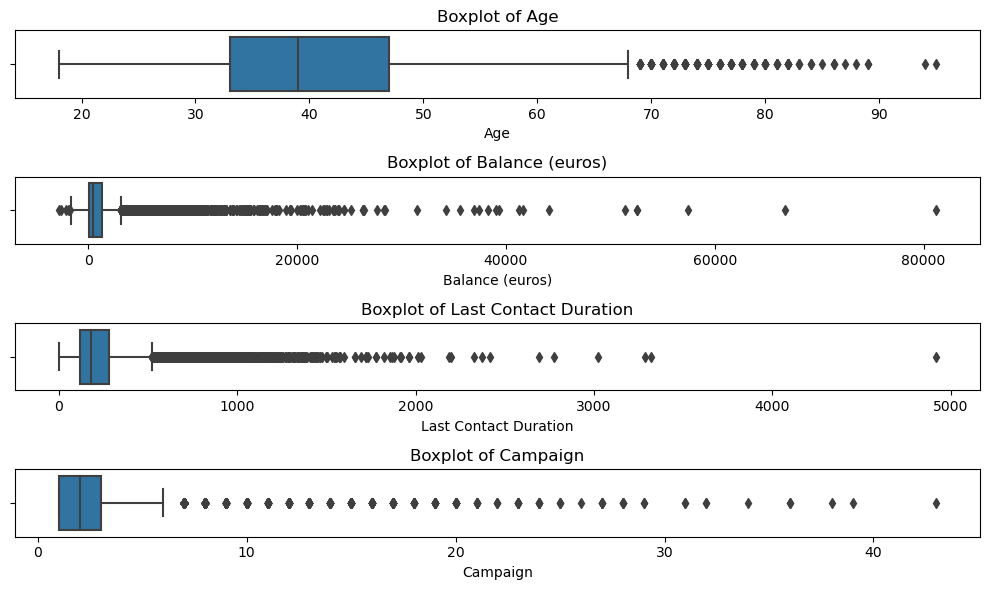

In [10]:
#Defino variables numéricas
numeric_columns = ['Age','Balance (euros)','Last Contact Duration', 'Campaign']


# Creo un boxplot para cada una
fig, axes = plt.subplots(nrows=len(numeric_columns), figsize=(10, 6))

for i, variable in enumerate(numeric_columns):
    sns.boxplot(x=df_no_un[variable], ax=axes[i])
    axes[i].set_title(f'Boxplot of {variable}')

plt.tight_layout()
plt.show()

Filtraremos el data frame para que quede entre los percentiles 1 y 99, pero solo para el balance y la duración del ultimo contacto, que es donde se ven outliers extremos

In [11]:
def clean_outliers(df):
    columns_to_filter = ['Balance (euros)','Last Contact Duration']

    # Generamos un diccionario de quantiles
    quantiles_dict = {}

    # Calculate and store quantiles for each numeric column
    for column in columns_to_filter:
        quantiles_dict[column + '_1'] = df[column].quantile(0.01)
        quantiles_dict[column + '_99'] = df[column].quantile(0.99)

    # Filter the DataFrame based on quantiles
    df_clean = df.copy()  # Create a copy to avoid modifying the original DataFrame

    for column in columns_to_filter:
        lower_limit = quantiles_dict[column + '_1']
        upper_limit = quantiles_dict[column + '_99']

        df_clean = df_clean[(df_clean[column] > lower_limit) & (df_clean[column] < upper_limit)]
        
    df_clean.reset_index(drop=True,inplace=True)
    
    return df_clean

In [12]:
df_clean = clean_outliers(df_no_un)

In [13]:
df_clean

,Age,Job,Marital Status,Education,Credit,Balance (euros),Housing Loan,Personal Loan,Contact,Last Contact Day,Last Contact Month,Last Contact Duration,Campaign,Pdays,Previous,Poutcome,Subscription
0,54.0,blue-collar,married,primary,no,466.0,no,no,cellular,4,jul,297.0,1,-1.0,0,unknown,0
1,43.0,blue-collar,married,secondary,no,105.0,no,yes,cellular,4,jul,180.0,2,-1.0,0,unknown,0
2,27.0,technician,single,secondary,no,126.0,yes,yes,cellular,4,jul,436.0,4,-1.0,0,unknown,0
3,50.0,blue-collar,married,secondary,no,1329.0,yes,yes,telephone,4,jul,141.0,2,-1.0,0,unknown,0
4,39.0,blue-collar,single,secondary,no,192.0,no,no,telephone,4,jul,112.0,2,-1.0,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10631,23.0,student,single,tertiary,no,113.0,no,no,cellular,17,nov,266.0,1,-1.0,0,unknown,1
10632,25.0,technician,single,secondary,no,505.0,no,yes,cellular,17,nov,386.0,2,-1.0,0,unknown,1
10633,71.0,retired,divorced,primary,no,1729.0,no,no,cellular,17,nov,456.0,2,-1.0,0,unknown,1
10634,72.0,retired,married,secondary,no,5715.0,no,no,cellular,17,nov,1127.0,5,184.0,3,success,1


Veamos sus boxplots ahora

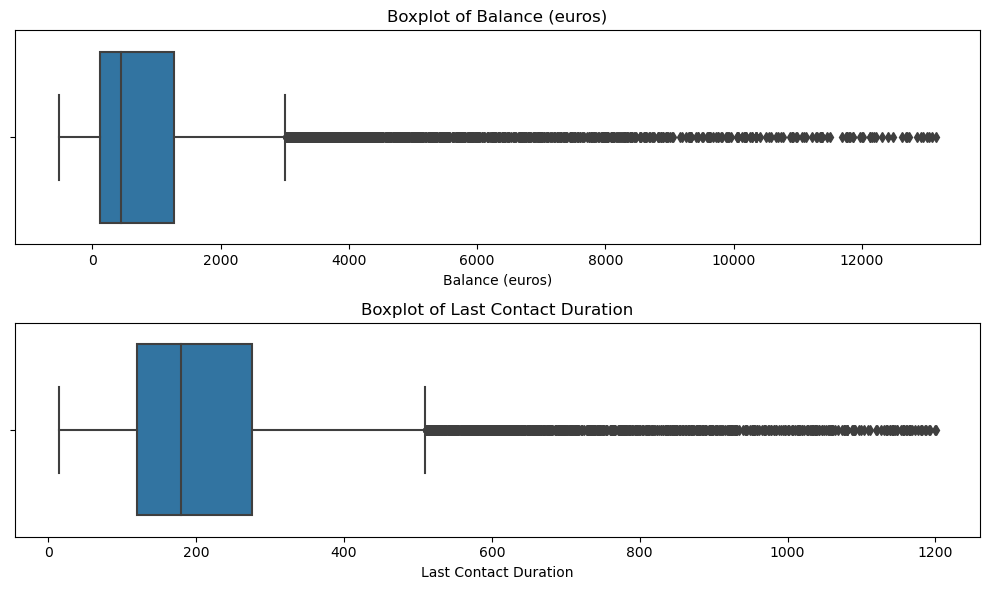

In [14]:
columns_to_filter = ['Balance (euros)','Last Contact Duration']

fig, axes = plt.subplots(nrows=len(columns_to_filter), figsize=(10, 6))

for i, variable in enumerate(columns_to_filter):
    sns.boxplot(x=df_clean[variable], ax=axes[i])
    axes[i].set_title(f'Boxplot of {variable}')

plt.tight_layout()
plt.show()

## Ingeniería de Atributos

Ahora que tenemos nuestros datos filtrados y limpiados, procedemos a prepararlos para ajustarlo a un modelo. Para eso, ciertas columnas tienen que sufrir transformaciones.

Primero, las columnas Credit, Housing Loan y Personal Loan seran transformadas de no/yes a 0/1

In [15]:
def yes_no(df):
    # Columnas a ser transformadas a yes/no
    columns_yes_no = ['Credit', 'Housing Loan', 'Personal Loan']

    df_yes_no = df.copy()

    # Cambio a 1/0
    df_yes_no[columns_yes_no] = df_yes_no[columns_yes_no].apply(lambda x: x.map({'yes': 1, 'no': 0}))

    return df_yes_no

In [16]:
df_yes_no = yes_no(df_clean)

Consideramos que la columna Pdays no es traducible directamente a un modelo. En vez de dar un número continuo donde -1 significa que no hubo contacto, lo separaremos en segmentos.

Veamos la distribución de esta columna (cuando no vale -1) para asi entender que segmentos generar.

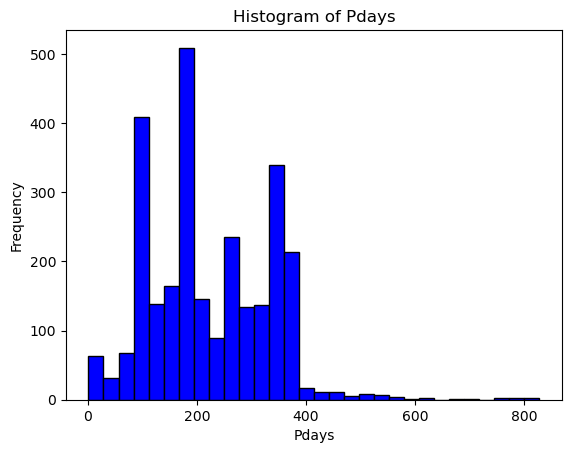

In [17]:
# Plot histogram
plt.hist(df_yes_no.query('Pdays != -1')['Pdays'], bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.title('Histogram of Pdays')
plt.xlabel('Pdays')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [18]:
def clusters(df):
    bins = [-np.inf, 0, 30, 90, 180, 360, np.inf]
    labels = ['No Contact', 'Contact Last Month', 'Contact 1 to 3 Months', 'Contact 3 to 6 Months', 'Contact 6 to 12 Months','Contact Over Year Ago']

    df_clusters = df.copy()

    df_clusters['Pdays'] = pd.cut(df_clusters['Pdays'], bins=bins, labels=labels, include_lowest=True)

    return df_clusters

In [19]:
df_clusters = clusters(df_yes_no)

El resto de las columnas, incluido ahora Pdays con sus clusters, se transformaran con One-Hot Encoding, ya que no tienen un orden jerarquico definido

In [20]:
def one_hot(df):
    one_hot_columns = ['Job','Marital Status','Contact','Poutcome','Education','Last Contact Month','Pdays']

    df_one_hot = pd.get_dummies(data=df, columns=one_hot_columns)
    #Se elimina la columna de unknown, ya que la información es dada por la columna Pdays. Si es -1 no se sabe el resultado, que esté dos veces es redundante y puede afectar al modelo.
    df_one_hot.drop('Poutcome_unknown',axis=1,inplace=True)

    return df_one_hot

In [21]:
df_one_hot = one_hot(df_clusters)

In [22]:
df_one_hot

,Age,Credit,Balance (euros),Housing Loan,Personal Loan,Last Contact Day,Last Contact Duration,Campaign,Previous,Subscription,...,Last Contact Month_may,Last Contact Month_nov,Last Contact Month_oct,Last Contact Month_sep,Pdays_No Contact,Pdays_Contact Last Month,Pdays_Contact 1 to 3 Months,Pdays_Contact 3 to 6 Months,Pdays_Contact 6 to 12 Months,Pdays_Contact Over Year Ago
0,54.0,0,466.0,0,0,4,297.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,43.0,0,105.0,0,1,4,180.0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
2,27.0,0,126.0,1,1,4,436.0,4,0,0,...,0,0,0,0,1,0,0,0,0,0
3,50.0,0,1329.0,1,1,4,141.0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
4,39.0,0,192.0,0,0,4,112.0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10631,23.0,0,113.0,0,0,17,266.0,1,0,1,...,0,1,0,0,1,0,0,0,0,0
10632,25.0,0,505.0,0,1,17,386.0,2,0,1,...,0,1,0,0,1,0,0,0,0,0
10633,71.0,0,1729.0,0,0,17,456.0,2,0,1,...,0,1,0,0,1,0,0,0,0,0
10634,72.0,0,5715.0,0,0,17,1127.0,5,3,1,...,0,1,0,0,0,0,0,0,1,0


Si bien se hizo una demostración paso a paso, se puede armar una gran función que haga todas las transformaciones de un solo paso

In [23]:
def apply_all_transformations(df):
    # Se aplican todas las transformaciones en orden
    df = fill_median(df)
    df = drop_na(df)
    # df = remove_unknown(df) ## Finalmente se decide no incluir este paso, ya sino perdemos datos y los score son peores
    df = clean_outliers(df)
    df = yes_no(df)
    df = clusters(df)
    df = one_hot(df)
    
    return df